In [574]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table
import exoplanet as xo
from scipy.optimize import curve_fit

In [575]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
file = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'

tbl = Table.read(file, format='fits')

q = tbl['QUALITY'] == 0
print(sum(q))

18506


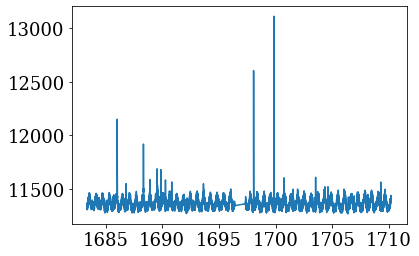

In [4]:
plt.plot(tbl['TIME'][q], tbl['PDCSAP_FLUX'][q])

In [7]:
# final period used in GJ 1243 - Kepler starspot paper
per_orig = 0.5925961953623503

BJD0 = 2454833. # Kepler time zeropoint
TJD0 = 2457000. # TESS time zeropoint

EPHEM = 0.11497024 # used to phase superwasp

In [ ]:
# acf = xo.autocorr_estimator(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q])-1 )

In [ ]:
# lnp = xo.lomb_scargle_estimator(data.time[q], data.psf_flux[q]/np.median(data.psf_flux[q])-1, 
#                                 min_period=0.2, max_period=5)

In [8]:
from lightkurve.search import search_lightcurvefile

In [11]:
lc0 = search_lightcurvefile('9726699', quarter=0, mission='Kepler', cadence='long').download()
kep=lc0.PDCSAP_FLUX
qk = kep.quality == 0

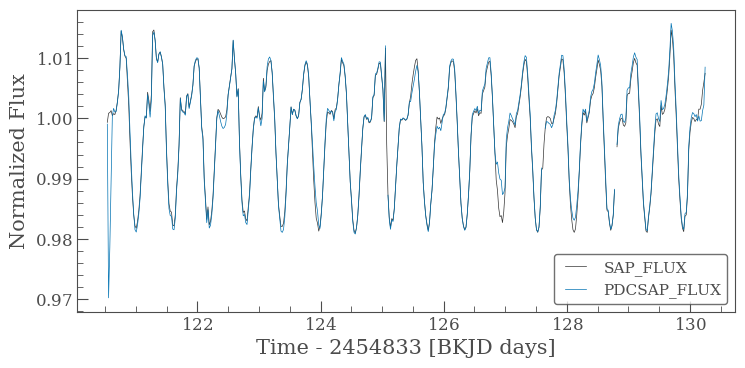

In [10]:
lc0.plot()

In [90]:
from scipy.stats import binned_statistic, binned_statistic_2d

def phase_mean(phase, flux, Nbins=100, stat='mean'):
    bins = np.linspace(-0.5, 1.5, Nbins)
    
    cln = np.isfinite(flux)
    ss = np.argsort(phase[cln])

    xd = np.hstack((phase[cln][ss]-1, phase[cln][ss], phase[cln][ss]+1))
    yd = np.hstack((flux[cln][ss], flux[cln][ss], flux[cln][ss]))
    bin_means, bin_edges, binnumber = binned_statistic(xd, yd, statistic=stat, 
                                                       bins=bins)
    bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2
    ok = np.isfinite(bin_means)
    return bin_centers[ok], bin_means[ok]
#     model = np.interp(x_i, bin_centers, bin_means)

In [16]:
def tau(mass): 
    ''' 
    Write up the Eqn 11 from Wright (2011) that gives the
    convective turnover timescale, used in Rossby number calculation (Ro =
    Prot / tau) 
    
    Parameters 
    ---------- 
    mass : float relative to solar 
    
    Returns
    ------- 
    tau (in days) 
    ''' 
    log_tau = 1.16 - 1.49 * np.log10(mass) - 0.54 * np.log10(mass)**2. 
    return 10.**log_tau

tau(0.2)

86.62503244871078

Text(0, 0.5, 'Relative Flux')

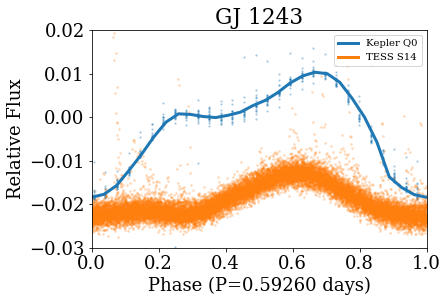

In [24]:

xk = ((kep.time - EPHEM) % per_orig)/per_orig
yk = kep.flux/np.nanmedian(kep.flux) - 1
plt.scatter(xk, yk, s=2, alpha=0.25, c='C0')

xxk,yyk = phase_mean(xk, yk, Nbins=55, stat='median')
plt.plot(xxk,yyk, lw=3, label='Kepler Q0')

# obnoxiously, convert time from TJD into KeplerBJD, so this EPHEM works too
xt = ((tbl['TIME'][q] + TJD0 - BJD0 - EPHEM) % per_orig) / per_orig
yt = tbl['PDCSAP_FLUX'][q]/np.median(tbl['PDCSAP_FLUX'][q])-1
plt.scatter(xt, yt - 0.02, s=3, alpha=0.2,c='C1')

xxt,yyt = phase_mean(xt, yt, Nbins=55, stat='median')
plt.plot(xxt,yyt - 0.02, lw=3, label='TESS S14')



plt.legend(fontsize=10)

plt.xlim(0,1)
plt.ylim(-0.03,0.02)
plt.title('GJ 1243')
plt.xlabel('Phase (P='+format(per_orig,'.5f')+' days)')
plt.ylabel('Relative Flux')

Text(0, 0.5, 'Relative Flux')

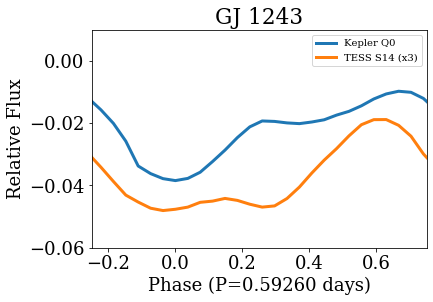

In [37]:
plt.plot(xxk,yyk - 0.02, lw=3, label='Kepler Q0')
plt.plot(xxt,yyt*3 - 0.04, lw=3, label='TESS S14 (x3)')

plt.legend(fontsize=10)

plt.xlim(-0.25,.75)
plt.ylim(-0.06,0.01)
plt.title('GJ 1243')
plt.xlabel('Phase (P='+format(per_orig,'.5f')+' days)')
plt.ylabel('Relative Flux')

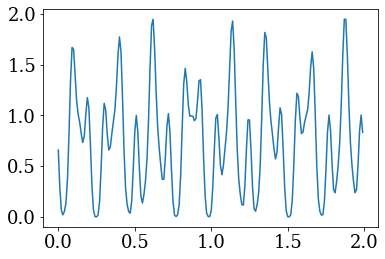

In [266]:
t = np.arange(0, 2, 0.01)

f1 = np.cos(t*2*np.pi / 0.5)**4
f2 = (np.sin(t*2*np.pi / 0.5)**4 + np.cos((t-0.3)*2*np.pi / 0.21)**4)

# plt.plot(t,f1)
plt.plot(t,f2)

In [36]:
KLC = search_lightcurvefile('9726699', mission='Kepler', cadence='long').download_all()


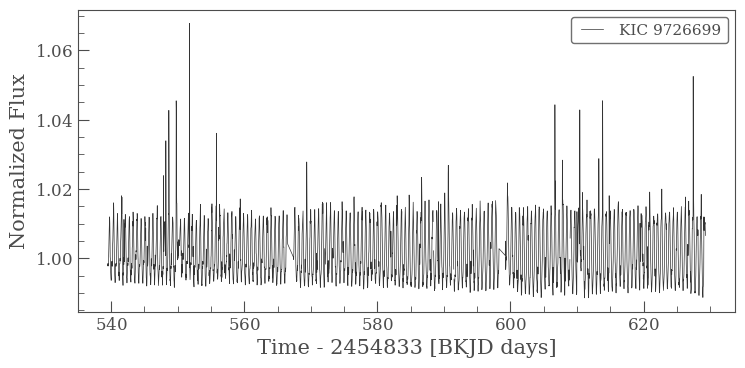

In [52]:
KLC[6].PDCSAP_FLUX.normalize().flatten(window_length=731).plot()

In [73]:
lc = KLC[0].PDCSAP_FLUX.normalize().flatten(window_length=731)
for k in range(2, len(KLC)):
    lc = lc.append(KLC[k].PDCSAP_FLUX.normalize().flatten(window_length=731))

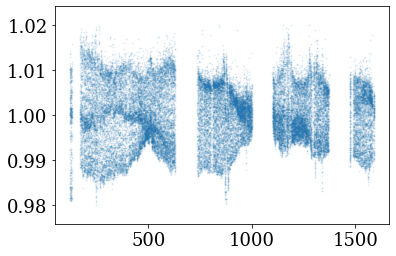

In [198]:
kok = (lc.quality == 0) & (lc.flux < 1.02) & (lc.flux > 0.98) #& (lc.time > 1050)

plt.scatter(lc.time[kok], lc.flux[kok], alpha=0.1, marker='.', s=3)

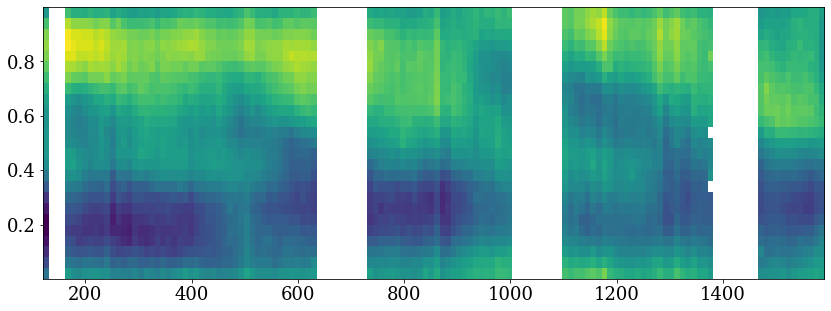

In [199]:
h, xe, ye,_ = binned_statistic_2d(lc.time[kok], (lc.time[kok] % per_orig)/per_orig, 
                                  lc.flux[kok], 
                                  bins=(140,25))

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))

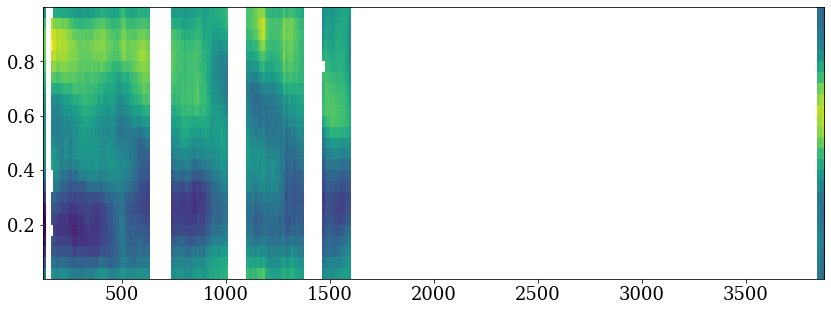

In [272]:
h, xe, ye,_ = binned_statistic_2d(np.hstack((lc.time[kok], tbl['TIME'][q] + TJD0 - BJD0 - EPHEM)), 
                                  np.hstack(((lc.time[kok] % per_orig)/per_orig, 
                                            ((tbl['TIME'][q] + TJD0 - BJD0 - EPHEM) % per_orig) / per_orig)),
                                  np.hstack((lc.flux[kok]-1, 2*(tbl['PDCSAP_FLUX'][q]/np.median(tbl['PDCSAP_FLUX'][q])-1))),
                                  bins=(300,25), statistic='median')

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))

In [366]:
# def twosine(x, a1, b1, p1, a2, b2, p2):
#     model = ((a1 * (np.sin((x-b1) * 2 * np.pi / p1)**4)) + 
#              (a2 * (np.cos((x-b2) * 2 * np.pi / p2)**4)))
#     return model

def twogaus(x, a1, x01, sigma1, a2, x02, sigma2, c):
    model = (a1 * np.exp(-(x - x01)**2 / (2 * sigma1**2)) + 
             a2 * np.exp(-(x - x02)**2 / (2 * sigma2**2)) + 
             a1 * np.exp(-(x - x01 - 1)**2 / (2 * sigma1**2)) + 
             a2 * np.exp(-(x - x02 - 1)**2 / (2 * sigma2**2)) +
             a1 * np.exp(-(x - x01 + 1)**2 / (2 * sigma1**2)) + 
             a2 * np.exp(-(x - x02 + 1)**2 / (2 * sigma2**2)) + c)
    return model 


def gaus(x, a, x0, sigma, b):
    """
    Simple Gaussian function
    
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian

    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b


In [271]:
# OOOOOOOK
# loop over the combined light curve,
# in each bin fit 2 gauss curves
# plot the center phase vs time

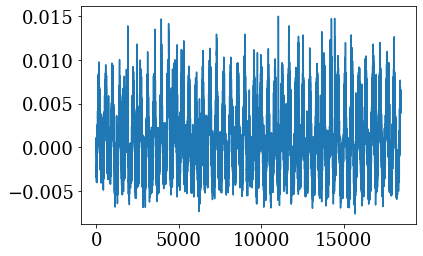

In [299]:
qok = (tbl['PDCSAP_FLUX'][q]/np.median(tbl['PDCSAP_FLUX'][q])-1) < 0.015

plt.plot((tbl['PDCSAP_FLUX'][q][qok]/np.median(tbl['PDCSAP_FLUX'][q][qok])-1))

In [308]:
time = np.hstack((lc.time[kok] - EPHEM, tbl['TIME'][q][qok] + TJD0 - BJD0 - EPHEM))
phase = np.hstack((((lc.time[kok] - EPHEM) % per_orig)/per_orig,
                   ((tbl['TIME'][q][qok] + TJD0 - BJD0 - EPHEM) % per_orig) / per_orig))
flux = np.hstack((lc.flux[kok]-1, 
                  2 * (tbl['PDCSAP_FLUX'][q][qok]/np.median(tbl['PDCSAP_FLUX'][q][qok])-1)))

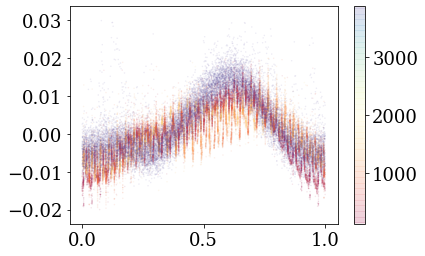

In [309]:
plt.scatter(phase, flux, s=1, marker='.', alpha=0.1, c=time, cmap=plt.cm.Spectral)
plt.colorbar()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


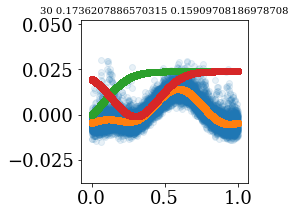

In [478]:
tbinsz = 40. # days
Nbin = (max(time) - min(time)) / tbinsz
btimes = np.linspace(min(time), max(time)+tbinsz, Nbin+1)
Npts, bin_edges = np.histogram(time, bins=btimes)

m1 = np.where((Npts > 50))[0]

g1 = []
g2 = []
tt = []

p0_0 = [-0.03, 0.01, 0.15, -0.015, 0.4, 0.1, 0.01]
bounds = ((-0.1, -0.5, 0, -0.1, -0.5, 0, 0), (0, 1.5, 0.5, 0, 1.5, 0.5, 0.5))

for k in range(len(m1)):
    ok = np.where((time > btimes[m1[k]]) & (time <= btimes[m1[k]+1]))[0]

    popt, pcov = curve_fit(twogaus, phase[ok], flux[ok], p0=p0_0, maxfev=9500, bounds=bounds)
    
    g1.append(popt[1])
    g2.append(popt[4])
    tt.append(np.mean(time[ok]))

    
    if k==30:
        plt.figure(figsize=(3,3))
        plt.scatter(phase[ok], flux[ok], alpha=0.1)
        plt.scatter(phase[ok], twogaus(phase[ok], *popt))
        plt.scatter(phase[ok], gaus(phase[ok], *popt[[0,1,2,6]]))
        plt.scatter(phase[ok], gaus(phase[ok], *popt[[3,4,5,6]]))
        plt.title(str(k)+' ' +str(popt[2])+' '+str(popt[5]),fontsize=10)
        plt.show()

g1 = np.array(g1)
g2 = np.array(g2)
tt = np.array(tt)

In [479]:
# h, xe, ye,_ = binned_statistic_2d(np.hstack((time,time,time)), 
#                                   np.hstack((phase-1,phase,phase+1)), 
#                                   np.hstack((flux,flux,flux)), 
#                                   bins=(300,55), statistic='median')

# plt.figure(figsize=(14,5))
# plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))
# plt.scatter(tt, g1, c='C1', edgecolors='white', lw=0.5)
# plt.scatter(tt, g1+1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)
# plt.scatter(tt, g1-1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)

# plt.scatter(tt, g2, c='C4', edgecolors='white', lw=0.5)
# plt.scatter(tt, g2+1, c='C4', edgecolors='white', lw=0.5)
# plt.scatter(tt, g2-1, c='C4', edgecolors='white', lw=0.5)

# plt.ylim(-0.5,1.5)

(-0.5, 1.5)

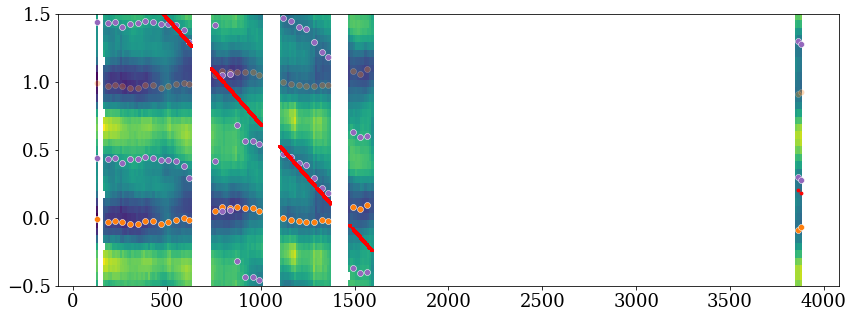

In [480]:
# hand pick the secondary spot range we're interested in
tl = np.where((tt > 500) & (tt < 1400))[0]
tfit = tt[tl]
gfit = g2[tl]

# manually fix for phase wrapping +1
gfit[(tfit < 790)] = gfit[(tfit < 790)] + 1

# fit a super simple model!
line = np.polyfit(tfit, gfit, 1)

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))
plt.scatter(tt, g1, c='C1', edgecolors='white', lw=0.5)
plt.scatter(tt, g1+1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)
plt.scatter(tt, g1-1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)

plt.scatter(tt, g2, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2+1, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2-1, c='C4', edgecolors='white', lw=0.5)

plt.scatter(time, np.polyval(line, time), s=2, c='red')
plt.scatter(tt[-2:], np.polyval(line, tt[-2:]) % 1, s=8, c='red')

plt.ylim(-0.5,1.5)

Text(0, 0.5, 'Relative Flux')

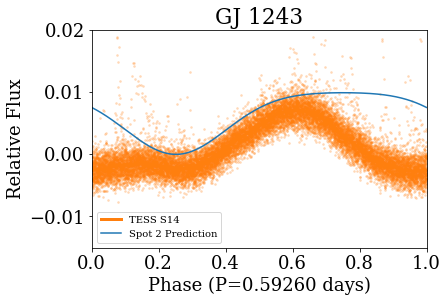

In [484]:

# xk = ((kep.time - EPHEM) % per_orig)/per_orig
# yk = kep.flux/np.nanmedian(kep.flux) - 1
# plt.scatter(xk, yk, s=2, alpha=0.25, c='C0')

# xxk,yyk = phase_mean(xk, yk, Nbins=55, stat='median')
# plt.plot(xxk,yyk, lw=3, label='Kepler Q0')

# obnoxiously, convert time from TJD into KeplerBJD, so this EPHEM works too
xt = ((tbl['TIME'][q] + TJD0 - BJD0 - EPHEM) % per_orig) / per_orig
yt = tbl['PDCSAP_FLUX'][q]/np.median(tbl['PDCSAP_FLUX'][q])-1
st = np.argsort(xt)
plt.scatter(xt, yt, s=3, alpha=0.2,c='C1')

xxt,yyt = phase_mean(xt, yt, Nbins=55, stat='median')
plt.plot(xxt,yyt, lw=3, label='TESS S14', c='C1')


predict = np.polyval(line, np.nanmean(xt)) % 1

plt.plot(xt[st], twogaus(xt[st], -0.01, predict, 0.15,0,0,0,0.01), label='Spot 2 Prediction')
plt.legend(fontsize=10)

plt.xlim(0,1)
plt.ylim(-0.015,0.02)
plt.title('GJ 1243')
plt.xlabel('Phase (P='+format(per_orig,'.5f')+' days)')
plt.ylabel('Relative Flux')

## A NEW Period?
The predicted secondary spot location, based on the Kepler 4yr rotation + linear shear, isn't bad!

But, could we use the entire light curve to get a *better* rotation period, and thus a better shear prediction?

Let's find out!

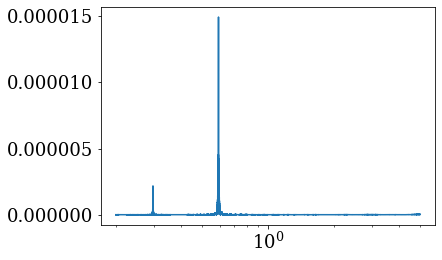

In [485]:
# a new period:
lnp = xo.lomb_scargle_estimator(time, flux, min_period=0.2, max_period=5)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
plt.xscale('log')

In [486]:
# very slightly different!
per_new = lnp['peaks'][0]['period']
print(per_new, per_orig)

0.5925976299591822 0.5925961953623503


In [487]:
phase = np.hstack((((lc.time[kok] - EPHEM) % per_new)/per_new,
                   ((tbl['TIME'][q][qok] + TJD0 - BJD0 - EPHEM) % per_new) / per_new))

In [488]:
tbinsz = 40. # days
Nbin = (max(time) - min(time)) / tbinsz
btimes = np.linspace(min(time), max(time)+tbinsz, Nbin+1)
Npts, bin_edges = np.histogram(time, bins=btimes)

m1 = np.where((Npts > 50))[0]

g1 = []
g2 = []
tt = []

p0_0 = [-0.03, 0.01, 0.15, -0.015, 0.4, 0.1, 0.01]
bounds = ((-0.1, -0.5, 0, -0.1, -0.5, 0, 0), (0, 1.5, 0.5, 0, 1.5, 0.5, 0.5))

for k in range(len(m1)):
    ok = np.where((time > btimes[m1[k]]) & (time <= btimes[m1[k]+1]))[0]
    popt, pcov = curve_fit(twogaus, phase[ok], flux[ok], p0=p0_0, maxfev=9500, bounds=bounds)
    
    g1.append(popt[1])
    g2.append(popt[4])
    tt.append(np.mean(time[ok]))

g1 = np.array(g1)
g2 = np.array(g2)
tt = np.array(tt)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 1.5)

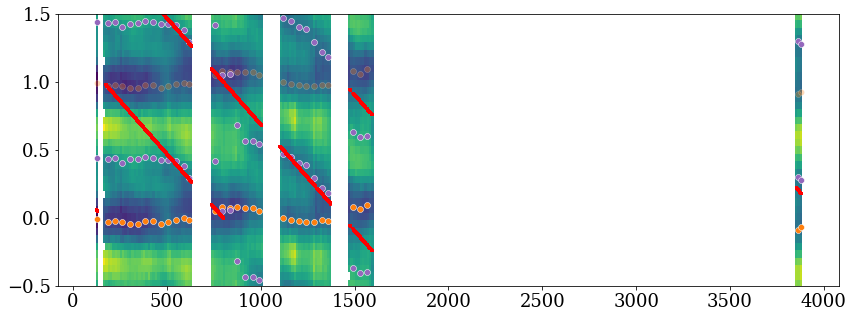

In [489]:
h, xe, ye,_ = binned_statistic_2d(np.hstack((time,time,time)), 
                                  np.hstack((phase-1,phase,phase+1)), 
                                  np.hstack((flux,flux,flux)), 
                                  bins=(300,55), statistic='median')

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))

plt.scatter(tt, g1, c='C1', edgecolors='white', lw=0.5)
plt.scatter(tt, g1+1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)
plt.scatter(tt, g1-1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)

plt.scatter(tt, g2, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2+1, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2-1, c='C4', edgecolors='white', lw=0.5)

plt.scatter(time, np.polyval(line, time), s=2, c='red')
plt.scatter(time, np.polyval(line, time) % 1, s=2, c='red')
# plt.scatter(tt[-2:], np.polyval(line, tt[-2:]) % 1, s=8, c='red')

plt.ylim(-0.5, 1.5)

[-1.56557018e-03  2.25224640e+00]


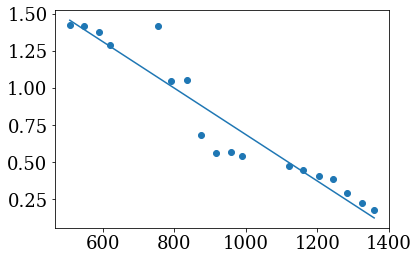

In [490]:
# hand pick the secondary spot range we're interested in
tl = np.where((tt > 500) & (tt < 1400))[0]
tfit = tt[tl]
gfit = g2[tl]

# manually fix for phase wrapping +1
gfit[(tfit < 790)] = gfit[(tfit < 790)] + 1

# fit a super simple model!
line = np.polyfit(tfit, gfit, 1)
plt.scatter(tfit, gfit)
plt.plot(tfit, np.polyval(line, tfit))

print(line)

In [491]:
(max(tfit) - min(tfit))/365

2.3285939842173207

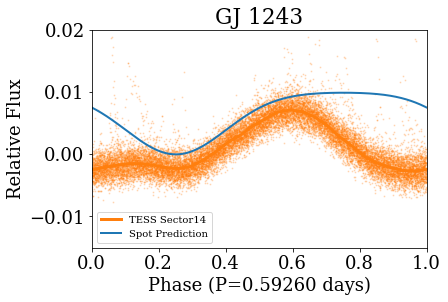

In [494]:
xt = ((tbl['TIME'][q] + TJD0 - BJD0 - EPHEM) % per_new) / per_new
yt = tbl['PDCSAP_FLUX'][q]/np.median(tbl['PDCSAP_FLUX'][q])-1
st = np.argsort(xt)
plt.scatter(xt, yt, s=1, alpha=0.2,c='C1')

xxt,yyt = phase_mean(xt, yt, Nbins=55, stat='median')
plt.plot(xxt,yyt, lw=3, label='TESS Sector14', c='C1')

predict_new = np.polyval(line, np.nanmean(xt)) % 1

plt.plot(xt[st], twogaus(xt[st], -0.01, predict_new, 0.15,0,0,0,0.01), label='Spot Prediction', lw=2)

plt.legend(fontsize=10)

plt.xlim(0,1)
plt.ylim(-0.015,0.02)
plt.title('GJ 1243')
plt.xlabel('Phase (P='+format(per_new,'.5f')+' days)')
plt.ylabel('Relative Flux')

plt.savefig('gj1243_spot_pred.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [468]:
(per_new - per_orig) / per_orig

2.420867435719647e-06

## More data!
So the prediction for TESS is very good - suspicously good even!

Can we find more data to fill the gaps?

In [495]:
# superwasp:
sw = pd.read_csv('swasp.tbl', delim_whitespace=True, skiprows=3, names=('x', 'HJD', 'tammag2'), usecols=(1,2))
sw.shape

(6164, 2)

(-0.1, 0.1)

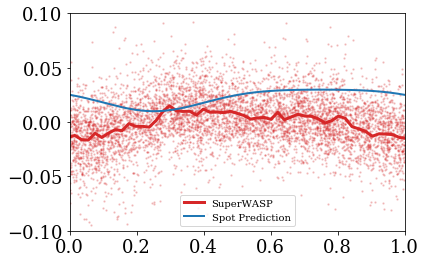

In [504]:
sok = (sw['HJD']-2.454e6 > 200) & (sw['tammag2']> 11) & (sw['tammag2'] < 12)
xs = ((sw['HJD'].values[sok]-BJD0-EPHEM) % per_new)/per_new
ys = 10**((np.nanmedian(sw['tammag2'][sok]) - sw['tammag2'].values[sok])/2.5)-1

plt.scatter(xs,ys, alpha=0.2, s=2, c='C3')

xxs,yys = phase_mean(xs, ys, Nbins=100)
plt.plot(xxs,yys, lw=3, label='SuperWASP', c='C3')

ss = np.argsort(xs)
predict_swasp = np.polyval(line, np.nanmean(xs)) % 1
plt.plot(xs[ss], twogaus(xs[ss], -0.02, predict_swasp, 0.15,0,0,0,0.03), label='Spot Prediction', lw=2)

plt.legend(fontsize=10)
plt.xlim(0,1)
plt.ylim(-0.1,.1)

In [505]:
# The prediction for SuperWASP is actually really BAD (but testable). Interesting!

(-0.5, 1.5)

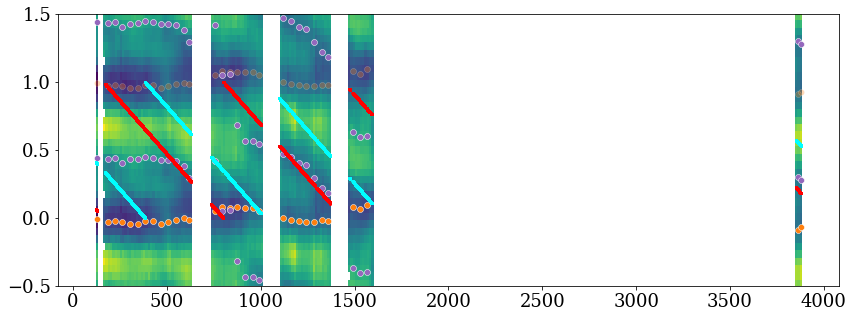

In [612]:
h, xe, ye,_ = binned_statistic_2d(np.hstack((time,time,time)), 
                                  np.hstack((phase-1,phase,phase+1)), 
                                  np.hstack((flux,flux,flux)), 
                                  bins=(300,55), statistic='median')

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))

plt.scatter(tt, g1, c='C1', edgecolors='white', lw=0.5)
plt.scatter(tt, g1+1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)
plt.scatter(tt, g1-1, c='C1', edgecolors='white', lw=0.5, alpha=0.3)

plt.scatter(tt, g2, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2+1, c='C4', edgecolors='white', lw=0.5)
plt.scatter(tt, g2-1, c='C4', edgecolors='white', lw=0.5)

# plt.scatter(time, np.polyval(line, time), s=2, c='red')
plt.scatter(time, np.polyval(line, time) % 1, s=2, c='red')

line2 = np.array([line[0], 0.6])
plt.scatter(time, np.polyval(line2, time) % 1, s=2, c='cyan')

plt.ylim(-0.5, 1.5)
# plt.xlim(0,600)

Text(0, 0.5, 'Relative Flux')

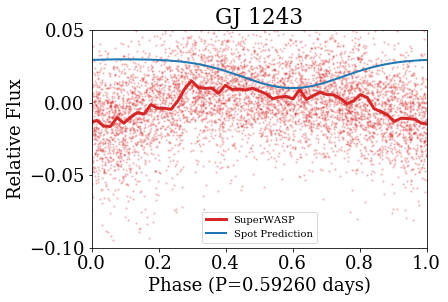

In [615]:
plt.scatter(xs,ys, alpha=0.2, s=2, c='C3')
plt.plot(xxs,yys, lw=3, label='SuperWASP', c='C3')

predict_swasp = np.polyval(line2, np.nanmean(xs)) % 1
plt.plot(xs[ss], twogaus(xs[ss], -0.02, predict_swasp, 0.15,0,0,0,0.03), label='Spot Prediction', lw=2)

plt.legend(fontsize=10)
plt.xlim(0,1)
plt.ylim(-0.1,.05)
plt.title('GJ 1243')
plt.xlabel('Phase (P='+format(per_new,'.5f')+' days)')
plt.ylabel('Relative Flux')

In [514]:
# ASAS-SN
asassn = pd.read_csv('light_curve_06498f2d-c182-4cb2-a014-3a398833fb81.csv')
asassn.columns

Index(['HJD', 'UT Date', 'Camera', 'FWHM', 'Limit', 'mag', 'mag_err',
       'flux(mJy)', 'flux_err', 'Filter'],
      dtype='object')

In [509]:
asassn['Filter'].unique()

array(['V', 'g'], dtype=object)

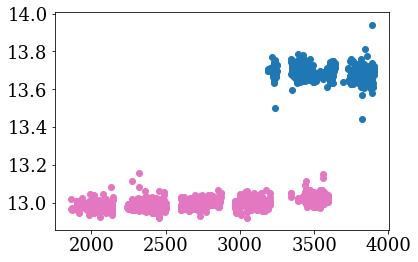

In [695]:
aokg = (asassn['mag'].str[0] == '1') & (asassn['Filter'] == 'g')
aokV = (asassn['mag'].str[0] == '1') & (asassn['Filter'] == 'V')

plt.scatter(asassn['HJD'][aokg]-BJD0, asassn['mag'][aokg].astype('float'))
plt.scatter(asassn['HJD'][aokV]-BJD0, asassn['mag'][aokV].astype('float'),c='C6')

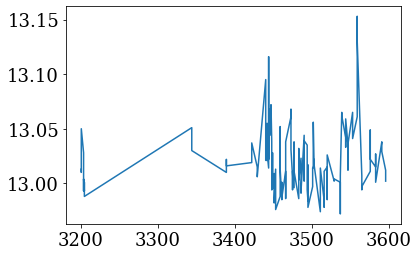

In [727]:
plt.plot(asassn['HJD'][aokV].values[t1]-BJD0, np.array(asassn['mag'][aokV].values, dtype='float')[t1])

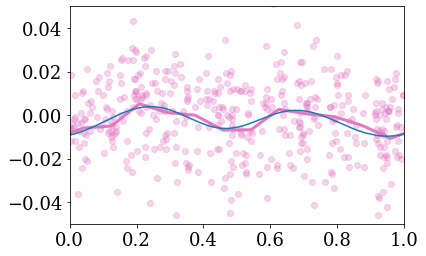

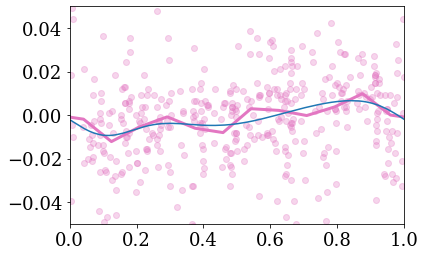

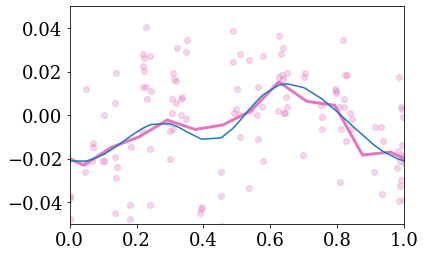

In [734]:
# xag = ((asassn['HJD'][aokg]-BJD0-EPHEM) % per_new)/per_new
# yag = asassn['flux(mJy)'][aokg] / np.nanmedian(asassn['flux(mJy)'][aokg]) - 1
# plt.scatter(xag, yag, alpha=0.2, s=5, c='C5')

trng = [[0, 2600], [2600,3300], [3300,4000]]
timetemp = asassn['HJD'][aokV].values - BJD0 - EPHEM

p0_0 = [-0.03, 0.01, 0.15, -0.015, 0.4, 0.1, 0.01]
bounds = ((-0.1, -0.5, 0.1, -0.1, -0.5, 0.1, 0), (0, 1.5, 0.3, 0, 1.5, 0.5, 0.5))
g1a=[]
g2a=[]
tta=[]
for k in range(np.shape(trng)[0]):
    
    t1 = np.where((timetemp >= trng[k][0]) & 
                  (timetemp <= trng[k][1]))[0]
    
    xaV = (timetemp[t1] % per_new)/per_new
    yaV = 10**((np.nanmedian(np.array(asassn['mag'][aokV], dtype='float')[t1]) - np.array(asassn['mag'][aokV], dtype='float')[t1])/2.5)-1

    popt, pcov = curve_fit(twogaus, xaV, yaV, p0=p0_0, maxfev=9500, bounds=bounds)
        
    g1a.append(popt[1])
    g2a.append(popt[4])
    tta.append(np.mean(timetemp[t1]))

    plt.figure()
    plt.scatter(xaV, yaV, alpha=0.3, c='C6', marker='o')
    xxaV,yyaV = phase_mean(xaV, yaV, Nbins=25)
    plt.plot(xxaV,yyaV, lw=3, label='ASAS-SN V', c='C6')
    
    saV = np.argsort(xaV)
    plt.plot(xaV[saV], twogaus(xaV[saV], *popt))

    plt.ylim(-0.05,.05)
    plt.xlim(0,1)
    plt.show()

g1a = np.array(g1a)
g2a = np.array(g2a)
tta = np.array(tta)



0.4993811066255351

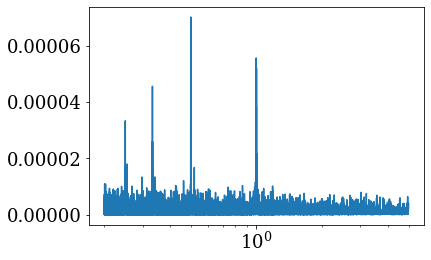

In [638]:
lnp = xo.lomb_scargle_estimator(asassn['HJD'][aokV], asassn['mag'][aokV].astype('float'),
                                min_period=0.2, max_period=5)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
plt.xscale('log')
lnp['peaks'][0]['period']

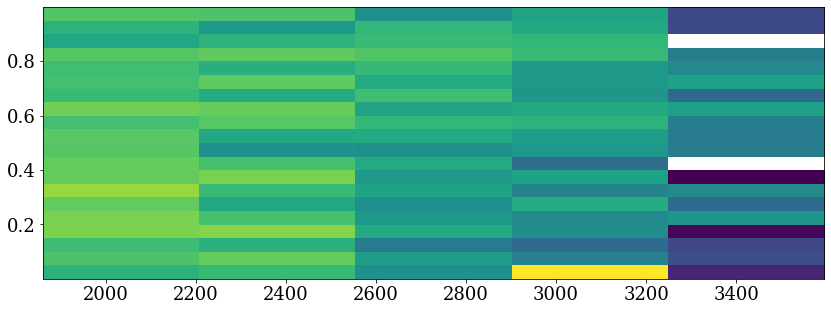

In [672]:

h, xe, ye,_ = binned_statistic_2d((asassn['HJD'][aokV]-BJD0-EPHEM), 
                                  ((asassn['HJD'][aokV]-BJD0-EPHEM) % per_new)/per_new, 
                                  10**((np.nanmedian(asassn['mag'][aokV].astype('float')) - asassn['mag'][aokV].astype('float'))/2.5)-1,
                                  bins=(5,20), statistic='median')

plt.figure(figsize=(14,5))
plt.imshow(h.T, origin='lower', aspect='auto', extent=(xe.min(), xe.max(), ye.min(), ye.max()))



In [547]:
# ASAS-SN has too low of Signal-to-noise for this target... not useful. A bit surprising

In [549]:
wise = pd.read_csv('WISE J195109.50+462903.0neowiser_p1bs_psd.csv')
wise.columns

Index(['Unnamed: 0', 'ra', 'dec', 'clon', 'clat', 'sigra', 'sigdec',
       'sigradec', 'w1mpro', 'w1sigmpro', 'w1snr', 'w1rchi2', 'w2mpro',
       'w2sigmpro', 'w2snr', 'w2rchi2', 'nb', 'na', 'cc_flags', 'ph_qual',
       'qual_frame', 'mjd', 'allwise_cntr', 'w1mpro_allwise',
       'w1sigmpro_allwise', 'w2mpro_allwise', 'w2sigmpro_allwise',
       'w3mpro_allwise', 'w3sigmpro_allwise', 'w4mpro_allwise',
       'w4sigmpro_allwise', 'tmass_key', 'j_m_2mass', 'j_msig_2mass',
       'h_m_2mass', 'h_msig_2mass', 'k_m_2mass', 'k_msig_2mass', 'dist',
       'angle'],
      dtype='object')

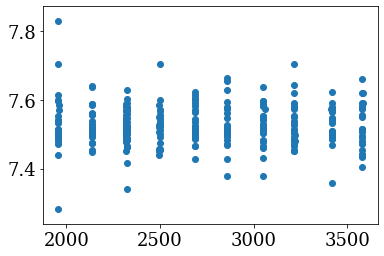

In [585]:
wok = wise['ph_qual'].str[0] == 'A'

# plt.errorbar(((wise['mjd'][wok]+2400000.5-BJD0-EPHEM) % per_new)/per_new, wise['w1mpro'][wok], 
#              yerr=wise['w1sigmpro'][wok], linestyle='None', marker='o', alpha=0.5)
plt.scatter(wise['mjd'][wok]+2400000.5-BJD0-EPHEM, wise['w1mpro'][wok])
# plt.xlim(2496,2500)

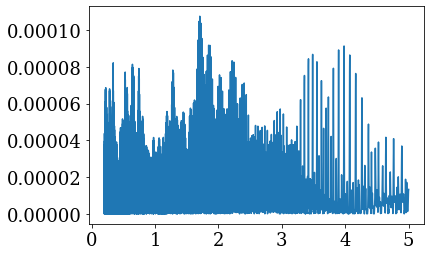

In [587]:
lnp = xo.lomb_scargle_estimator(wise['mjd'][wok]+2400000.5-BJD0-EPHEM, wise['w1mpro'][wok],
                                min_period=0.2, max_period=5)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
# plt.xscale('log')

In [589]:
# Nothing useful in WISE - no shock there